In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, hinge_loss
import matplotlib.pyplot as plt
from sklearn.utils import resample
import matplotlib.colors as mcolors
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.decomposition import PCA

In [2]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import StandardScaler
# from sklearn.svm import SVC
# from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_curve, auc, RocCurveDisplay, hinge_loss
# import matplotlib.pyplot as plt
# from sklearn.utils import resample
# import matplotlib.colors as mcolors
# from sklearn.inspection import DecisionBoundaryDisplay
# from sklearn.decomposition import PCA

In [3]:
%%time
df_main = pd.read_csv('../../Dataset/IDS 2018 Intrusion CSVs (CSE-CIC-IDS2018)/dataset_dos.csv')

CPU times: total: 406 ms
Wall time: 509 ms


In [4]:
len(df_main)

393636

In [5]:
len(df_main[df_main['Label'] == 0])

196818

In [6]:
len(df_main[df_main['Label'] == 1])

196818

In [7]:
df_normal = df_main[df_main['Label'] == 0]
df_attack = df_main[df_main['Label'] == 1]

In [8]:
df_normal_downsampled = resample(df_normal, replace=False, n_samples=5000, random_state=42)
len(df_normal_downsampled)

5000

In [9]:
df_attack_downsampled = resample(df_attack, replace=False, n_samples=5000, random_state=42)
len(df_attack_downsampled)

5000

In [10]:
df_downsample = pd.concat([df_normal_downsampled, df_attack_downsampled])
len(df_downsample)

10000

In [11]:
# X = df_downsample.drop(columns='Label')
# y = df_downsample['Label']

# # Chia dữ liệu thành tập huấn luyện và tập kiểm tra
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
X = df_main.drop(columns='Label')
y = df_main['Label']

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
scaler = StandardScaler()
X_train_scaled  = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

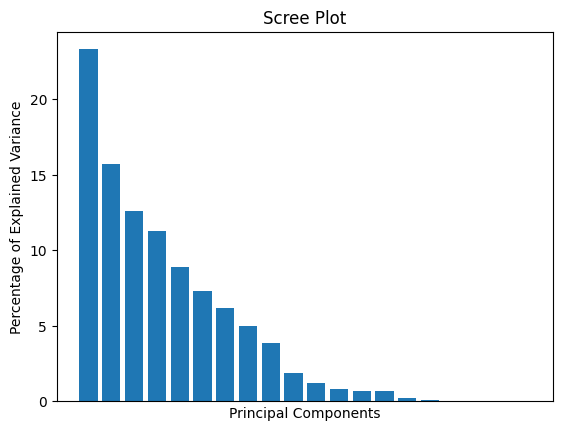

In [14]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_*100, decimals=1)
labels = [str(x) for x in range(1, len(per_var)+1)]

plt.bar(x=range(1, len(per_var)+1), height=per_var)
plt.tick_params(
    axis='x',
    which='both',
    bottom=False,
    top=False,
    labelbottom=False)

plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Components')
plt.title('Scree Plot')
plt.show()

In [15]:
# %%time
# pca = PCA(n_components=2)
# X_train_pca = pca.fit_transform(X_train_scaled)

# train_pc1_coords = X_train_pca[:, 0]
# train_pc2_coords = X_train_pca[:, 1]
# pca_train_scaled = StandardScaler().fit_transform(np.column_stack((train_pc1_coords, train_pc2_coords)))

# param_grid = [
#     {'C': [1, 10, 100, 1000],
#      'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
#      'kernel': ['rbf']},
# ]

# optimal_params = GridSearchCV(
#     SVC(),
#     param_grid,
#     cv=5,
#     scoring='accuracy',
#     verbose=3
# )

# optimal_params.fit(pca_train_scaled, y_train)
# print(optimal_params.best_params_)

In [16]:
%%time

pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
# Huấn luyện mô hình SVM với kernel RBF trên dữ liệu PCA
# clf_svm_pca = SVC(random_state=42, **optimal_params.best_params_)
clf_svm_pca = SVC(random_state=42, C=100, gamma=1, kernel='rbf')
clf_svm_pca.fit(X_train_pca, y_train)

CPU times: total: 22min 36s
Wall time: 29min 20s


SVC(C=100, gamma=1, random_state=42)

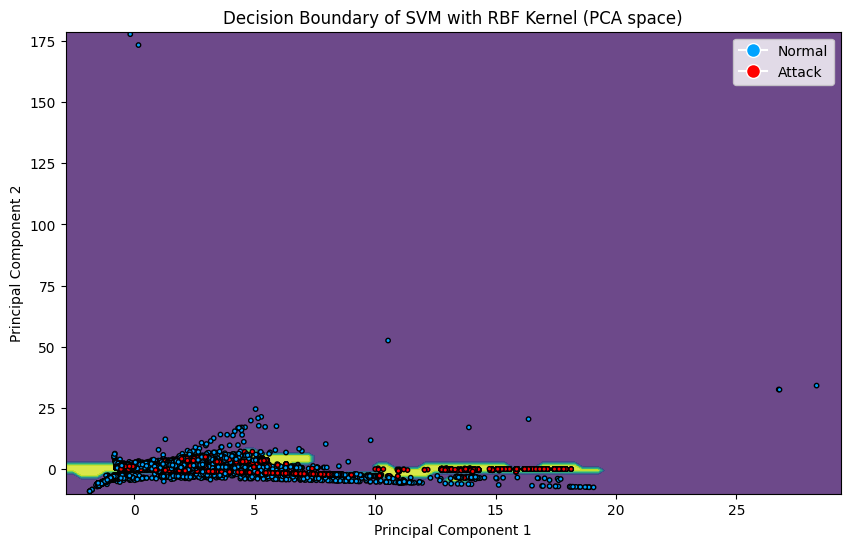

In [17]:
# Hiển thị ranh giới quyết định
fig, ax = plt.subplots(figsize=(10, 6))

cmap = mcolors.ListedColormap(['#00A3FF', '#FF0000']) 

# DecisionBoundaryDisplay từ sklearn.inspection
DecisionBoundaryDisplay.from_estimator(clf_svm_pca, X_train_pca, response_method="predict", alpha=0.8, cmap='viridis', ax=ax)

# Vẽ scatter plot của dữ liệu PCA
scatter = ax.scatter(X_train_pca[:, 0], X_train_pca[:, 1], c=y_train, cmap=cmap, edgecolors='k', s=10)

# Thêm các thông số cho biểu đồ
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Decision Boundary of SVM with RBF Kernel (PCA space)')
# ax.set_xlim(-50, 50)
# ax.set_ylim(-50, 50)

# Tạo chú thích tùy chỉnh
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#00A3FF', markersize=10, label='Normal'),
           plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='#FF0000', markersize=10, label='Attack')]

ax.legend(handles=handles, loc='upper right')

plt.show()

In [18]:
# Dự đoán nhãn của tập huấn luyện
y_pred = clf_svm_pca.predict(X_train_pca)

# Đánh giá độ chính xác
accuracy = accuracy_score(y_train, y_pred)
precision = precision_score(y_train, y_pred)
recall = recall_score(y_train, y_pred)
f1 = f1_score(y_train, y_pred)
loss = hinge_loss(y_train, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'Hinge Loss: {loss}')

Accuracy: 0.9685622467514322
Precision: 0.9537861094038107
Recall: 0.9848884883410974
F1-Score: 0.9690878093560897
Hinge Loss: 0.5310947959404017


In [19]:
# Dự đoán nhãn của tập kiểm tra
y_pred = clf_svm_pca.predict(X_test_pca)

# Đánh giá độ chính xác
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
loss = hinge_loss(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')
print(f'Hinge Loss: {loss}')

Accuracy: 0.9682832029265318
Precision: 0.9544094741266349
Recall: 0.9833656001630324
F1-Score: 0.9686711917995559
Hinge Loss: 0.5330886088812112


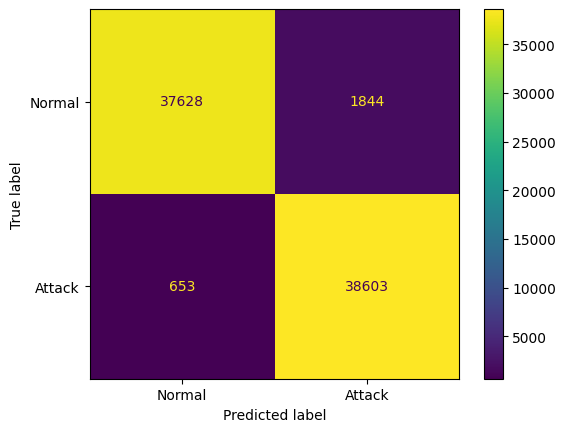

In [20]:
# Tính ma trận nhầm lẫn
cm = confusion_matrix(y_test, clf_svm_pca.predict(X_test_pca))

# Hiển thị ma trận nhầm lẫn
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Normal", "Attack"])
disp.plot(values_format='d')

In [21]:
# y_score = clf_svm_pca.decision_function(X_test_pca)
# fpr, tpr, _ = roc_curve(y_test, y_score)
# roc_auc = auc(fpr, tpr)
# print(f'ROC AUC: {roc_auc}')
# RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc).plot()

In [22]:
# print(classification_report(y_test, y_pred))

In [23]:
# from sklearn.pipeline import Pipeline
# from sklearn.model_selection import cross_val_score, learning_curve

# # Tạo pipeline
# pipeline = Pipeline([
#     ('scaler', StandardScaler()),  # Bước chuẩn hóa dữ liệu
#     ('svm', SVC(random_state=42, C=1000, gamma=1, kernel='rbf'))  # Bước huấn luyện mô hình SVM
# ])

# # Sử dụng cross-validation để đánh giá mô hình
# cv_scores = cross_val_score(pipeline, X_train, y_train, cv=10)
# print(f'Cross-validation scores: {cv_scores}')
# print(f'Mean cross-validation score: {np.mean(cv_scores)}')

# # Vẽ đường cong học tập
# train_sizes, train_scores, test_scores = learning_curve(pipeline, X_train, y_train, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10))

# train_scores_mean = np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)

# plt.figure()
# plt.title('Learning Curves')
# plt.xlabel('Training examples')
# plt.ylabel('Score')
# plt.grid()

# plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.1, color="r")
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.1, color="g")
# plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
# plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# plt.legend(loc="best")
# plt.show()

In [24]:
# from sklearn.model_selection import cross_val_score, learning_curve

# # Calculate learning curves
# train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
#     clf_svm_pca, X_train_scaled, y_train, cv=10, return_times=True, scoring='neg_mean_squared_error', n_jobs=-1
# )

# # Calculate mean and standard deviation
# train_scores_mean = -np.mean(train_scores, axis=1)
# train_scores_std = np.std(train_scores, axis=1)
# test_scores_mean = -np.mean(test_scores, axis=1)
# test_scores_std = np.std(test_scores, axis=1)

# # Plot learning curves
# plt.figure()
# plt.title("Loss Curves")
# plt.xlabel("Training examples")
# plt.ylabel("Loss")
# plt.grid()

# plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
#                  train_scores_mean + train_scores_std, alpha=0.1,
#                  color="r")
# plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
#                  test_scores_mean + test_scores_std, alpha=0.1, color="g")
# plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
#          label="Training loss")
# plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
#          label="Cross-validation loss")

# plt.legend(loc="best")
# plt.show()

In [29]:
import joblib

joblib.dump(scaler, '../Test/scaler_model.joblib')

# Lưu mô hình pca vào một file
joblib.dump(pca, '../Test/pca_model.joblib')

# Lưu mô hình SVM vào một file
joblib.dump(clf_svm_pca, '../Test/svm_model.joblib')

['../Test/svm_model.joblib']